In [1]:
import seaborn as sns
from parse_touchpad_data import TouchpadData
from sklearn.mixture import BayesianGaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


In [11]:
legal = np.array(TouchpadData('../touchpad_capture/real_data/legal').data)
illegal = np.array(TouchpadData('../touchpad_capture/real_data/illegal').data)

nontouch = np.array(TouchpadData('../touchpad_capture/real_data/nontouches').data)
touch = np.concatenate((legal, illegal)) # Doesn't matter if it's a finger (legal) or a palm (illegal), only care if it's touching the touchpad or not

three_finger = TouchpadData('dataset/rotate/original').data[0]


<AxesSubplot:>

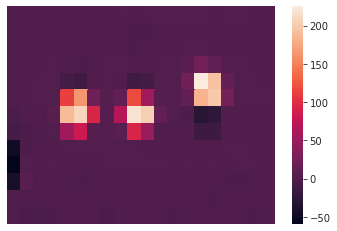

In [12]:
image = three_finger
sns.heatmap(image, xticklabels=False, yticklabels=False)

In [13]:
touch_features = pd.DataFrame({
    "min": np.min(touch, axis=(1,2)),
    "max": np.max(touch, axis=(1,2)),
    "mean": np.mean(touch, axis=(1,2)),
    "var": np.var(touch, axis=(1,2)),
    "sum": np.sum(touch, axis=(1,2)),
    "ptp": np.ptp(touch, axis=(1,2)),
    "std": np.std(touch, axis=(1,2)),
    "trace": np.trace(touch, axis1=1, axis2=2),

    "target": 0
})

nontouch_features = pd.DataFrame({
    "min": np.min(nontouch, axis=(1,2)),
    "max": np.max(nontouch, axis=(1,2)),
    "mean": np.mean(nontouch, axis=(1,2)),
    "var": np.var(nontouch, axis=(1,2)),
    "sum": np.sum(nontouch, axis=(1,2)),
    "ptp": np.ptp(nontouch, axis=(1,2)),
    "std": np.std(nontouch, axis=(1,2)),
    "trace": np.trace(nontouch, axis1=1, axis2=2),

    "target": 1
})

features = pd.concat((nontouch_features, touch_features))

In [17]:
features.columns[:]

Index(['min', 'max', 'mean', 'var', 'sum', 'ptp', 'std', 'trace', 'target'], dtype='object')

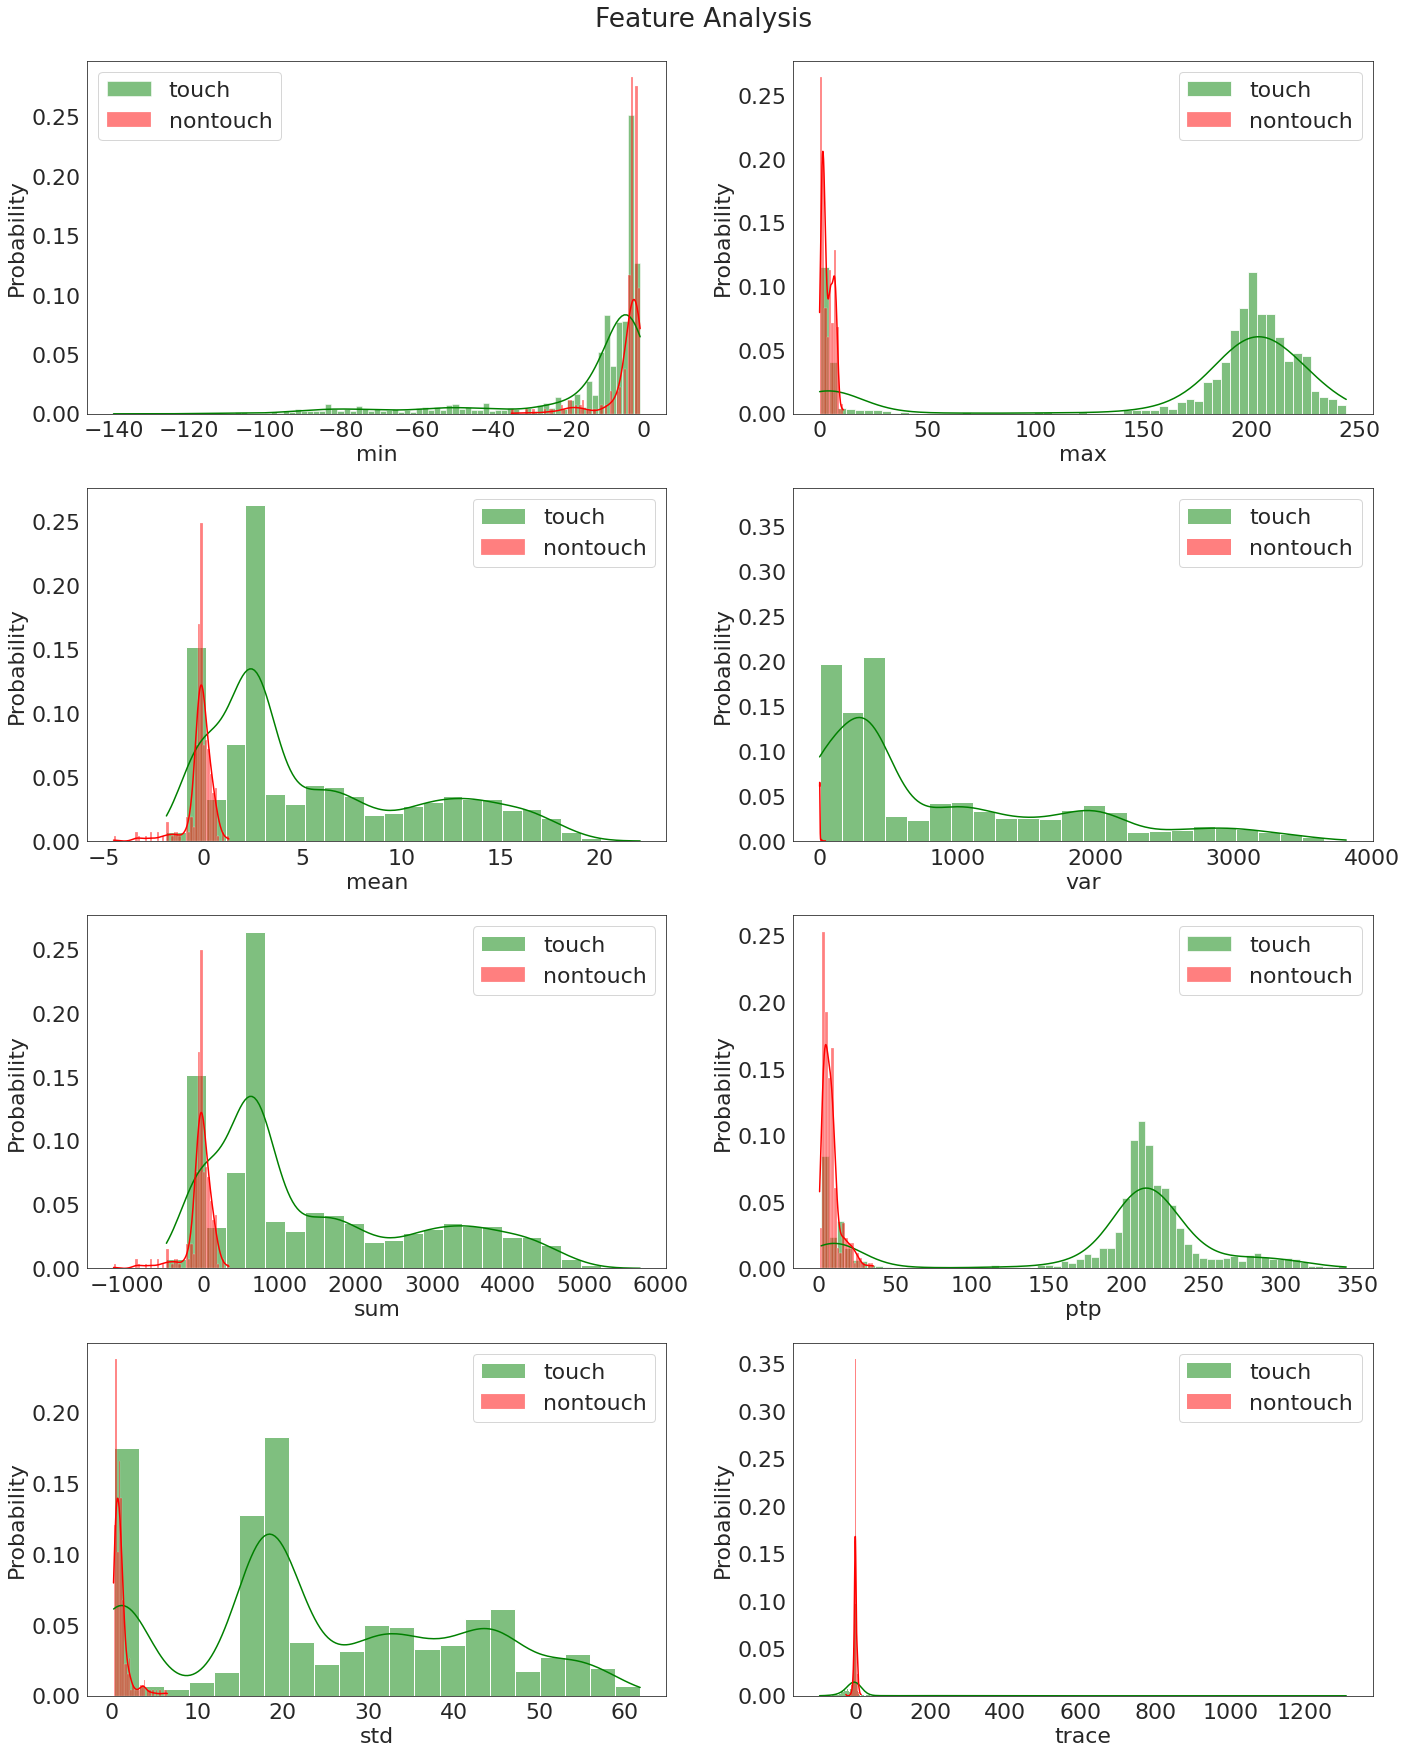

In [19]:
fig = plt.figure(figsize = (20, 25))
plt.rcParams.update({'font.size': 22})
i = 1
for feature in features.columns[: features.columns.slice_locs(end='trace')[1]]: # Cycle through columns until and including "trace"
    plt.subplot(4, 2, i)
    sns.histplot(data=touch_features, x=feature, kde=True, stat="probability", color='g', label='touch')
    sns.histplot(data=nontouch_features, x=feature, kde=True, stat="probability", color='r', label='nontouch')
    plt.legend(loc='best')
    i += 1
fig.suptitle('Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('data_elimination_feature_distribution.pdf')

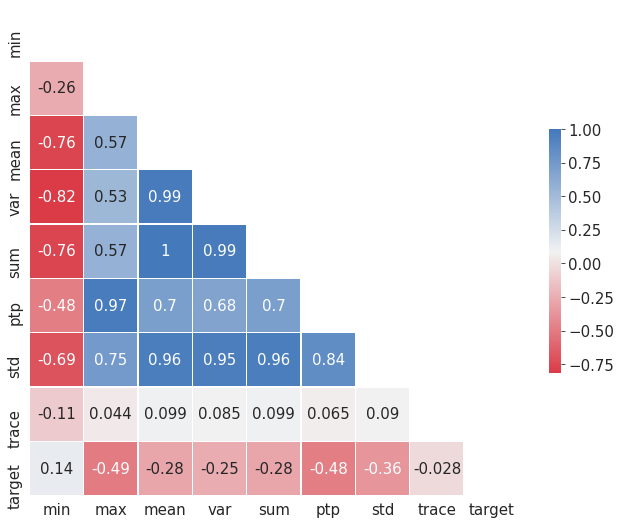

In [22]:
corr = features.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.set_style(style = 'white')
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.savefig('data_elimination_feature_corr.pdf')